In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("src/")
import operator
from importlib import reload
import src.preprocessing.data_loading as data_loading
import models.experiment as experiment
import models.rnn as rnn
import analysis.umap_analysis as umap
import analysis.scatter_plots as scatter_plots
import analysis.evaluation as evaluation
from preprocessing.X_representation import RAA_to_seq
from preprocessing.X_representation_utils import initialize_Proc2Vec_embeddings
from utils.utils import find_3mer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras

2023-02-08 17:13:15.610255: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 17:13:36.515302: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/ml_phage/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Train MDM2 vs. 12ca5 Model



In [6]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
R3_lib['Length'] = [len(seq) for seq in R3_lib['Peptide']]
R3_lib_seq9 = R3_lib.loc[(R3_lib['Length'] == 9)].copy()

protein_of_interest = "MDM2"
other_protein = "12ca5"
(
    X,
    mdm2_y,
    mdm2_y_raw,
    ca5_y,
    ca5_y_raw,
    peptides,
    FEATURE_LIST,
) = data_loading.build_dataset(
    R3_lib_seq9,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    aa_representations=[
        data_loading.AA_REPRESENTATION.PRO2VEC,
        data_loading.AA_REPRESENTATION.RAA,
        data_loading.AA_REPRESENTATION.PHYSIOCHEM_PROPERTIES,
    ],
)
# Big TODO: clean up the way things are split into test/train...
(
    X_train,
    X_test,
    mdm2_y_train,
    mdm2_y_test,
    ca5_y_train,
    ca5_y_test,
    peptides_train,
    peptides_test,
    results,
) = experiment.BinaryClassificationExperiment().run_adhoc_experiment(
    X,
    mdm2_y,
    ca5_y,
    peptides,
    rnn.Joint_BinaryClassificationRNN_gelu,
    load_trained_model=True,
    model_save_name="my_model/",
)
mdm2_model = results.trained_model
mdm2_y_pred_raw = mdm2_model(X_test)
mdm2_y_pred = mdm2_y_pred_raw > 0.5

print("MDM2")
evaluation.classification_evaluation_joint(mdm2_y_test, mdm2_y_pred)

/Users/yitongtseo/Documents/GitHub/ml_phage_display/src/preprocessing/y_representation.py:66: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib["pvalues"] = sp.stats.ttest_ind(


 - log P value cutoff is -0.548611409986568, and log FC value cutoff is -0.5635823330227997
MDM2
P-VAL
	 accuracy:  0.6963844599146642
	 precision:  0.6965129358830147
	 recall:  0.9990319457889641
	 # neg predictions:  8
	 # pos predictions:  4445
Log Fold
	 accuracy:  0.8349427352346732
	 precision:  0.833291739455952
	 recall:  0.9803288314738696
	 # neg predictions:  446
	 # pos predictions:  4007


In [7]:
# compute 12ca5 preditions by reversing MDM2 FC preditions
ca5_y_pred_raw_derived_from_mdm2 = np.copy(mdm2_y_pred_raw)
ca5_y_pred_raw_derived_from_mdm2[:, 1] = 1-ca5_y_pred_raw_derived_from_mdm2[:,1]
ca5_y_pred_derived_from_mdm2 = ca5_y_pred_raw_derived_from_mdm2 > 0.5

# Create ca5_y_test from mdm2_y_test (TODO: this is inelegant... and should be done straight from the results of data_loading.build_dataset)
ca5_y_test = np.copy(mdm2_y_test)
ca5_y_test[:, 1] = ca5_y_test[:, 1] == 0

print('\n12ca5 Derived from inverted MDM2 Model Output')
# evaluate accuracy, precision, recall of trianed model
evaluation.classification_evaluation_joint(ca5_y_test, ca5_y_pred_derived_from_mdm2)



12ca5 Derived from inverted MDM2 Model Output
P-VAL
	 accuracy:  0.6963844599146642
	 precision:  0.6965129358830147
	 recall:  0.9990319457889641
	 # neg predictions:  8
	 # pos predictions:  4445
Log Fold
	 accuracy:  0.8349427352346732
	 precision:  0.8497757847533632
	 recall:  0.36198662846227314
	 # neg predictions:  4007
	 # pos predictions:  446


## Hit Rate by BiLSTM Model Confidence Ranking 

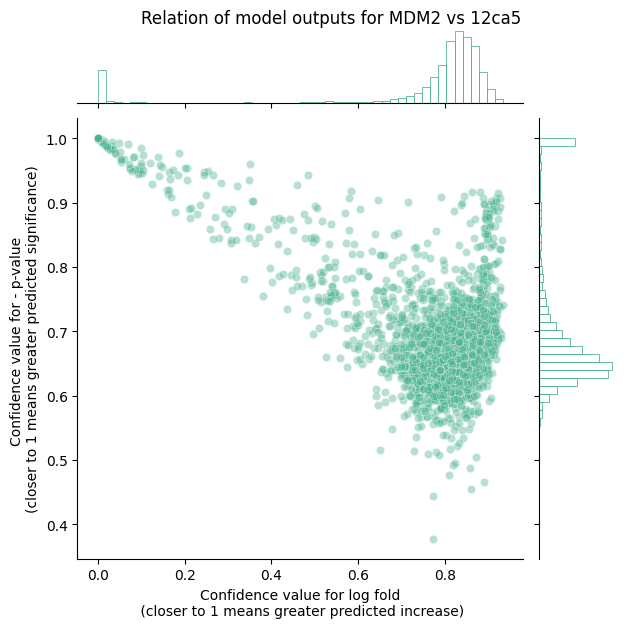

In [8]:
import matplotlib.pyplot as plt
import matplotlib


def show_volcano(y, protein_of_interest, other_protein, title, x_label, y_label):
    sns.set_palette(sns.color_palette("plasma"))
    p = sns.jointplot(
        x=y[:, 1],
        y=y[:, 0],
        color="#4CB391",
        alpha=0.4,
        marginal_kws=dict(bins=50, fill=False),
    )  
    p.fig.suptitle(title)
    p.set_axis_labels(x_label, y_label)
    p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 



show_volcano(
    mdm2_model(X_test),
    protein_of_interest,
    other_protein,
    title=f"Relation of model outputs for {protein_of_interest} vs {other_protein}",
    x_label="Confidence value for log fold\n (closer to 1 means greater predicted increase)",
    y_label="Confidence value for - p-value \n(closer to 1 means greater predicted significance)",
)


normalized MDM2 area under curve:  0.6628923633493183
normalized 12ca5 area under curve:  0.9661403458800404


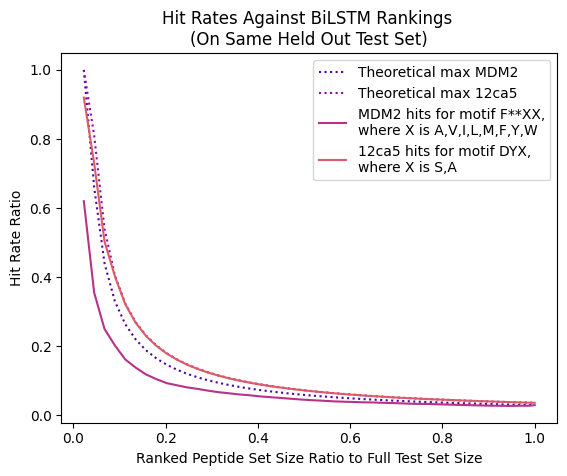

mdm2 hits!  ['AFCDWFWWS', 'AFCDWFWCF', 'AFCDFFWCS', 'AFCYWFWCS', 'AFCDWFFCS', 'AFCDWFWCT', 'AFYDWFWCS', 'AFCYWFWCA', 'AFCDWIWCA', 'AFCDWIWCS', 'AFFVWFWCS', 'AFWDWFECN', 'AFCVWFWCY', 'AFCVWIWCA', 'AFCVWLWCA', 'AFCDWFVCN', 'AFWVWVWCS', 'AFFVLFWCS', 'AFCDWIWCC', 'AFCVWFWCF', 'AFCDWLWCC', 'AFFVWVWCS', 'AFCFWLWCS', 'AFCVWFWWS', 'AFCFWIWCS', 'AFCDWFRCS', 'AFCVWFWCS', 'AFCYWFVCN', 'AFCDWFECS', 'AFCDWYWCS', 'AFCDWVWCC', 'AFCDWFLCC', 'AFCDWVWCY', 'AFCDWIRCS', 'AFCYWFWCY', 'AFCDWLRCS', 'AFCVWIWCS', 'AFCAWFWCC', 'AFCDWFDCN', 'AFCDLIWCS', 'AFSTFECFW', 'AFCDLLWCS', 'AFCDWVWCP', 'AFSDWIWCS', 'AFCFWFECN', 'AFCVLFWCC', 'ACTTFEWWW', 'AFCDWFECT', 'AFCYWVLCS', 'AFCYLFLCS', 'AFCDWLECN', 'AFCVWILCS', 'AFCVWFWGS', 'AFCDYFYCN', 'AFCVWFRCS', 'AFCVWVWGS', 'ACLTFMCWW', 'AFCAWFECN', 'AFCYWFVCI', 'ACKPFMCWW', 'ACTCFECWW', 'ACYSFRCMA', 'ACTTFLCWW', 'ACKSFMCWW', 'ACLSFMCWW', 'ACTSFMCWW', 'ACSSFECWW', 'ACWGFRCIL', 'AFCGWYNCV', 'AFCGLAGCL', 'ACFLRAFCA', 'ACKTFLCWL', 'AFCGAAVCR', 'AFCDWFEGN', 'ACSSFLCWA', 'ACSKFSCYF',

In [9]:
# Can we just literally reverse the prediction of the fc and get 12ca5 predictions?
ca5_y_pred_raw = np.copy(mdm2_y_pred_raw)
ca5_y_pred_raw[:, 1] = 1-ca5_y_pred_raw[:,1]

from analysis.hit_rate_analysis import plot_ratio_by_ranking

plot_ratio_by_ranking(peptides_test, mdm2_y_pred_raw, ca5_y_pred_raw, title='Hit Rates Against BiLSTM Rankings \n(On Same Held Out Test Set)')

## Hit Rate by Volcano Plot Ground Truth

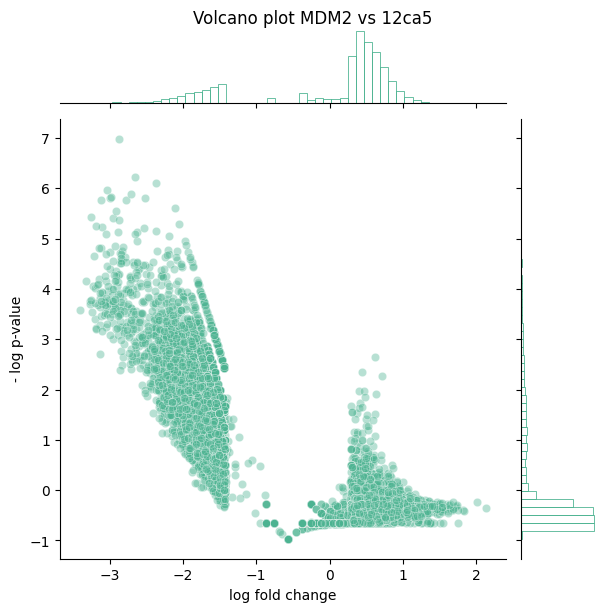

In [10]:
show_volcano(
    mdm2_y_raw,
    protein_of_interest,
    other_protein,
    title=f"Volcano plot {protein_of_interest} vs {other_protein}",
    x_label="log fold change",
    y_label="- log p-value",
)


In [11]:
from analysis.hit_rate_analysis import plot_ratio_by_ranking

plot_ratio_by_ranking(
    peptides_test,
    mdm2_y_raw_test,
    ca5_y_raw_test,
    title="Hit Rates Against Volcano Plot Rankings \n(On Same Held Out Test Set)",
)


NameError: name 'mdm2_y_raw_test' is not defined